In [2]:

import sys
path='/home/tomas/Ulmer-Berechnung/alps2qutipplus-april/alps2qutipplus-main/'

sys.path.insert(1, path) 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qutip
import scipy.linalg as linalg
import time
from multiprocessing import Pool
from itertools import product
from typing import Optional

import alpsqutip.parallelized_functions_and_workers as plME

from alpsqutip import (build_system, list_models_in_alps_xml,
                       list_geometries_in_alps_xml, graph_from_alps_xml,
                       model_from_alps_xml,
                       restricted_maxent_toolkit as me)

from alpsqutip.operators.states.utils import safe_exp_and_normalize ## function used to safely and robustly map K-states to states

from alpsqutip.scalarprod import fetch_covar_scalar_product
from alpsqutip.operators.states.gibbs import GibbsDensityOperator, GibbsProductDensityOperator

In [4]:

from alpsqutip.operators.arithmetic import (
    ScalarOperator,
    LocalOperator,
    OneBodyOperator,
    Operator,
    ProductOperator,
    ScalarOperator,
    SumOperator,
    QutipOperator
)

from alpsqutip.operators.simplify import simplify_sum_operator

In [5]:
params={}

params['size']=4
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y



In [6]:

params = {
    'size': 4,           # number of sites
    'Nmax': 4,           # max number of bosons per site
    't': 1.0,            # hopping parameter
    'U': 1.0,            # on-site interaction
}

system = build_system(
    geometry_name="open chain lattice",
    model_name="boson Hubbard",
    L=params['size'],
    Nmax=params['Nmax']
)


loading model boson Hubbard  over graph open chain lattice


In [7]:
system = build_system(geometry_name="open chain lattice", model_name="fermion", 
                      L=params['size'], J=1)

sites = system.sites 
c_ups = [system.site_operator("c_up", str(site)) for site in sites]


loading model fermion  over graph open chain lattice


In [15]:
(c_ups[0] * c_ups[1] - c_ups[1] * c_ups[0]).norm()

0.0

In [10]:
tgt_obs = c_ups[0].dag() * c_ups[0+1] + c_ups[0+1].dag() * c_ups[0]

In [11]:
HBB0=[tgt_obs,  c_ups[1].dag() * c_ups[1+1] + c_ups[1+1].dag() * c_ups[1]]

phi0 = np.array([.25, .25])
K0 = phi0@HBB0
sigma0 = GibbsDensityOperator(K0)
phi0[0] = np.log(sigma0.tr())
K0 = phi0@HBB0
sigma0 = GibbsDensityOperator(K0)

In [35]:
H = 0
for i in range(len(sites) - 1):
    H += c_ups[i].dag() * c_ups[i+1] + c_ups[i+1].dag() * c_ups[i]

In [37]:
bench_op = c_ups[0].dag() * c_ups[0+1] 

p_op = plME.general_worker(("projection", (bench_op, 1, sigma0)))

In [16]:
p_op

0 * Identity_{1[0],1[1],1[2],1[3]} 

In [17]:
c_ups[0].dag() * (c_ups[0+1] * sigma0).tr() + c_ups[1].dag() * (c_ups[0] * sigma0).tr() - (bench_op * sigma0).tr()

  ((-0-0j) * Identity_{1[0],1[1],1[2],1[3]} )

In [18]:
timespan=np.linspace(.0, 100/vLR,100)
evs_obs_ex=qutip.mesolve(H=H.to_qutip(), rho0=sigma0.to_qutip()
                         , tlist=timespan, e_ops=[tgt_obs.to_qutip()])

In [19]:
evs_obs_ex.expect[0]

array([ 0.00000000e+00, -5.46527591e-04, -2.16274046e-03, -4.77743741e-03,
       -8.27656121e-03, -1.25058646e-02, -1.72790428e-02, -2.23869513e-02,
       -2.76046610e-02, -3.27009804e-02, -3.74544788e-02, -4.16539176e-02,
       -4.51151210e-02, -4.76863817e-02, -4.92531591e-02, -4.97474408e-02,
       -4.91484296e-02, -4.74804623e-02, -4.48171481e-02, -4.12771480e-02,
       -3.70137425e-02, -3.22161198e-02, -2.70952083e-02, -2.18761469e-02,
       -1.67887484e-02, -1.20569948e-02, -7.88903977e-03, -4.46821369e-03,
       -1.94504405e-03, -4.30623810e-04,  8.29212353e-06, -6.47555242e-04,
       -2.36928869e-03, -5.08120265e-03, -8.66404452e-03, -1.29601335e-02,
       -1.77803271e-02, -2.29125849e-02, -2.81311487e-02, -3.32064269e-02,
       -3.79150292e-02, -4.20495844e-02, -4.54282541e-02, -4.79024215e-02,
       -4.93631937e-02, -4.97462159e-02, -4.90345605e-02, -4.72596001e-02,
       -4.44994326e-02, -4.08754464e-02, -3.65470332e-02, -3.17047238e-02,
       -2.65616916e-02, -

In [20]:
simulations={}
sp_local = fetch_covar_scalar_product(sigma0)

from scipy.linalg import cho_solve, cho_factor
       
simulations[1] = {
    "parms":{
    "chosen_depth": 6,
    "m0": 2,
    "eps": 1e-3,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

current_simulation = simulations[1]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]
num_workers = 1

In [43]:
simulations={}
sp_local = fetch_covar_scalar_product(sigma0)

from scipy.linalg import cho_solve, cho_factor
       
simulations[1] = {
    "parms":{
    "chosen_depth": 6,
    "m0": 2,
    "eps": 1e-3,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

current_simulation = simulations[1]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]
num_workers = 1

In [46]:
HBB_ell_non_act=plME.parallelized_real_time_projection_of_hierarchical_basis(
    generator=H,
    seed_op=tgt_obs,
    sigma_ref=GibbsDensityOperator(1e-10*H),
    nmax=m0,
    deep=4,
    num_workers=num_workers,
    tidy_thresh = 1e-20
)


In [64]:
sp_local_non_act=me.fetch_covar_scalar_product(sigma=sigma0) ## choosing of the scalar product
HBB_ell_non_act= [tgt_obs, 1j*me.commutator(H, tgt_obs), 1j*me.commutator(H, 1j*me.commutator(H, tgt_obs))]
HBB_ell_non_act+=[1j*me.commutator(H, HBB_ell_non_act[-1])]
HBB_ell_non_act+=[1j*me.commutator(H, HBB_ell_non_act[-1])]
#HBB_ell_non_act+=[1j*me.commutator(H, HBB_ell_non_act[-1])]

Gram_matrix_non_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_non_act, 
                                                       sp = sp_local_non_act,
                                                       num_workers=num_workers)
R_non_act = np.linalg.cholesky(Gram_matrix_non_act).conj().T

b_orth= linalg.inv(R_non_act.T) @ HBB_ell_non_act

Hij_tensor_non_act_non_orth = plME.compute_Hij_tensor_non_orth(
    basis = HBB_ell_non_act, 
    generator = H, 
    sp = sp_local_non_act,
    sigma_ref = sigma0,
    nmax = m0,
    Gram = Gram_matrix_non_act,
            num_workers=num_workers
)

Hij_tensor_non_act = (linalg.inv(R_non_act).T 
                  @ Hij_tensor_non_act_non_orth 
                  @ linalg.inv(R_non_act)) ### In this convention for R_act, the orthonormal Hij_orth is
                                           ### Hij_orth = (R**-1).T @ Hij_non_orth @ (R**-1)
    
phi0_proj_non_act = np.array([sp_local_non_act(tgt_obs, op) for op in b_orth])
new_obs_local=(phi0_proj_non_act @ b_orth).simplify()
print("Fita: Check", ((new_obs_local.to_qutip() - tgt_obs.to_qutip())).norm())

phi_at_timet = np.array([
    (linalg.expm(Hij_tensor_non_act*(t-.0)) @ phi0_proj_non_act) for t in timespan
])

K_at_timet = [(phit @ b_orth).simplify() for phit in phi_at_timet]
#sigma_at_timet = [GibbsDensityOperator(Kt) for Kt in K_at_timet]
evs_non_act = [(GibbsDensityOperator(K0).to_qutip() * obs_local.to_qutip()).tr()
               for obs_local in K_at_timet]

Fita: Check 0.0


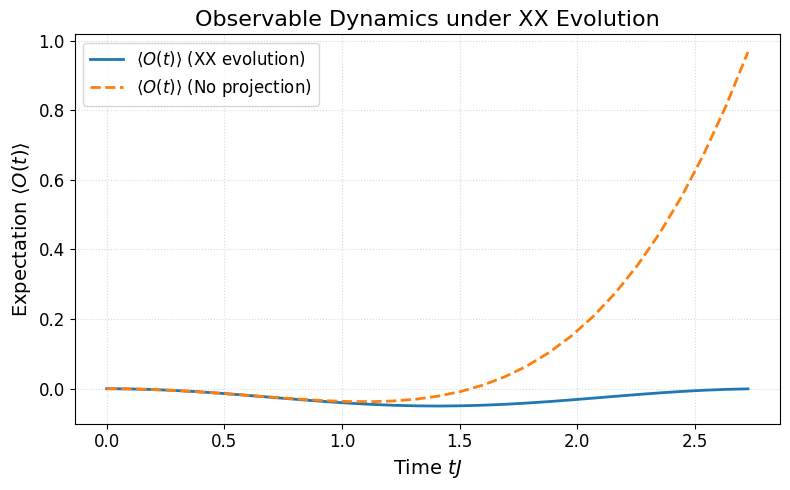

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

m=30

# Plot both curves with labels
plt.plot(timespan[:m], evs_obs_ex.expect[0][:m], label=r'$\langle O(t) \rangle$ (XX evolution)', lw=2)
plt.plot(timespan[:m], evs_non_act[:m], label=r'$\langle O(t) \rangle$ (No projection)', lw=2, linestyle='--')

# Labels and title
plt.xlabel(r'Time $tJ$', fontsize=14)
plt.ylabel(r'Expectation $\langle O(t) \rangle$', fontsize=14)
plt.title('Observable Dynamics under XX Evolution', fontsize=16)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


In [26]:
HBB_ell_non_act[-1]

(
qutip interface operator for 1 x  
Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+0.j       0.+0.j       0.+0.j       0.+0.j       0.+0.j
  0.+0.j       0.+0.j       0.+0.j      ]
 [0.+0.j       0.+0.j       0.+0.j       0.+0.j       0.+0.015625j
  0.+0.j       0.+0.j       0.+0.j      ]
 [0.+0.j       0.+0.j       0.+0.j       0.+0.j       0.+0.j
  0.+0.j       0.+0.j       0.+0.j      ]
 [0.+0.j       0.+0.j       0.+0.j       0.+0.j       0.+0.j
  0.+0.j       0.-0.015625j 0.+0.j      ]
 [0.+0.j       0.-0.015625j 0.+0.j       0.+0.j       0.+0.j
  0.+0.j       0.+0.j       0.+0.j      ]
 [0.+0.j       0.+0.j       0.+0.j       0.+0.j       0.+0.j
  0.+0.j       0.+0.j       0.+0.j      ]
 [0.+0.j       0.+0.j       0.+0.j       0.+0.015625j 0.+0.j
  0.+0.j       0.+0.j       0.+0.j      ]
 [0.+0.j       0.+0.j       0.+0.j       0.+0.j       0.+0.j
  0.+0.j       0.+0.j       0.+0.j      ]]
  +qutip interface oper